In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from copy import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


from sklearn.metrics import mean_absolute_error, mean_squared_error

from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor

from tqdm import tqdm_notebook

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
def add_std(data):
    data["amount_std"] = np.zeros(data.shape[0])
    
    for user in data["customer_id"].unique():
        data[data.customer_id == user]["amount_std"] = data[data.customer_id == user]["amount"].mean() - data[data.customer_id == user]["amount"]
    
    return data

In [3]:
data = pd.read_csv("train_set.csv")
data.head(3)

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_adress_lat,pos_adress_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
0,2.884034,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,11606fde0c814ce78e0d726e39a0a5ee,2017-07-15,59.847,30.177
1,2.775633,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,e9647a5e1eacfb06713b6af755ccc595,2017-10-27,59.847,30.177
2,3.708368,NaN,NaN,NaN,St Petersburg,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5992,"PR.MARSHALA ZHUKOVA,31St Petersburg190000 7...",59.858198,30.229024,df06c1fcd3718a514535ae822785f716,2017-10-03,59.847,30.177


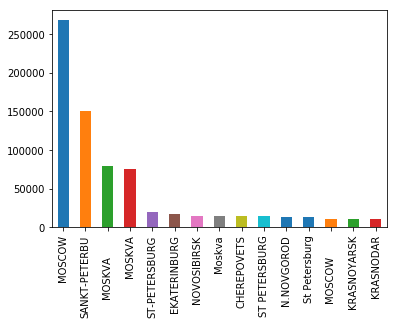

In [4]:
data.city.value_counts()[:15].plot(kind="bar")
plt.show()

In [5]:
replaces_city = {
    "PETER": "ST-PETERBUG",
    "MOSK": "MOSCOW",
    "MOSC": "MOSCOW"
}

def prepear_city_name(city):
    city = city.replace(" ", "")
    city = city.replace("g.", "")
    
    for c1, c2 in replaces_city.items():
        if c1 in city:
            city = c2
    
    return city.upper()

In [6]:
def get_means_amount(data):
    sums = dict()
    counts = dict()
    
    for user, amount in zip(data["customer_id"], data["amount"]):
        sums[user] = sums.get(user, 0) + amount 
        counts[user] = counts.get(user, 0) + 1
    
    for i in sums:
        sums[i]/=counts[i]
    
    return sums

def add_std_amount(data):
    astd = []
    mean_amount = get_means_amount(data)
    
    for user, amount in zip(data["customer_id"], data["amount"]):
        astd.append(mean_amount[user]-amount)
    
    return astd

def add_means(data):
    ameans = []
    mean_amount = get_means_amount(data)
    
    for user in data["customer_id"]:
        ameans.append(mean_amount[user])
    
    return ameans

In [7]:
data["is_atm"] = data.atm_address_lat.isna()
data["tx_lat"] = data.atm_address_lat
data["tx_lon"] = data.atm_address_lon

data["tx_lat"][data.tx_lat.isna()] = data.pos_adress_lon[data.tx_lat.isna()]
data["tx_lon"][data.tx_lon.isna()] = data.pos_adress_lon[data.tx_lon.isna()]
data = data[["customer_id", "city", "amount", "currency", "mcc", "tx_lat", "tx_lon", "work_add_lat", "work_add_lon", "home_add_lat", "home_add_lon"]]

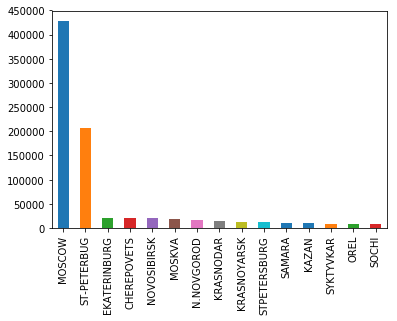

In [8]:
city_encoder = LabelEncoder()

data = data[np.invert(data.tx_lat.isna())]

data["city"] = data["city"].fillna("None")
data["city"] = data["city"].apply(prepear_city_name)

data.city.value_counts()[:15].plot(kind="bar")
plt.show()

data["city"] = city_encoder.fit_transform(data["city"])
city_counts = data["city"].value_counts()
data["city_counts"] = data["city"].apply(lambda x: city_counts[x])

data["std_amount"] = add_std_amount(data)
data["std_amount_sq"] = data["std_amount"]**2
data["mean_amount"] = add_means(data)

# data["dispersion"] = data.customer_id.apply(lambda x: calc_dispersion(x, data))

X = data[["city", "city_counts", "amount", "currency", "mcc", "std_amount", "std_amount_sq", "mean_amount"]]

Y_home = np.sqrt(((data[["tx_lat", "tx_lon"]].get_values() - data[["home_add_lat", "home_add_lon"]].get_values())**2).sum(axis=1))
Y_work = np.sqrt(((data[["tx_lat", "tx_lon"]].get_values() - data[["work_add_lat", "work_add_lon"]].get_values())**2).sum(axis=1))

In [9]:
categorical_features = ["city", "currency", "mcc"]

In [10]:
X_home = X[np.invert(np.isnan(Y_home))]
Y_home = Y_home[np.invert(np.isnan(Y_home))]

X_work = X[np.invert(np.isnan(Y_work))]
Y_work = Y_work[np.invert(np.isnan(Y_work))]

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X_home, Y_home, test_size=0.33, shuffle=True, random_state=321)

model_home = LGBMRegressor(n_estimators=800, max_depth=5, categorical_features=categorical_features)
model_home.fit(x_train, y_train)

pred = model_home.predict(x_test)

print(pred)
print(y_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("MSE:", mean_squared_error(y_test, pred))

[18.67637089  5.03544866 18.53517833 ... 18.18855949 29.34982066
 18.28023065]
[18.61292153  3.00750663 18.16111671 ... 19.27008364 29.56553609
 17.28494597]
MAE: 1.7814061089542155
MSE: 31.678914655770257


In [12]:
model_home.feature_importances_

array([5577, 6281, 1125,   59, 2609,  782,  718, 4187])

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X_work, Y_work, test_size=0.33, shuffle=True, random_state=321)

model_work = LGBMRegressor(n_estimators=800, max_depth=5, categorical_features=categorical_features)
model_work.fit(x_train, y_train)

pred = model_work.predict(x_test)

print(pred)
print(y_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("MSE:", mean_squared_error(y_test, pred))

[18.32888614 18.30967227 29.93817182 ... 18.12693326  1.53495095
 18.26411391]
[18.12433188 18.38921069 29.43722938 ... 18.16103574  0.04455334
 18.38903162]
MAE: 1.4354280597242748
MSE: 21.424748565442467


## Предсказание

In [14]:
test_data = pd.read_csv("test_set.csv")
test_data.head()

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date
0,2.211818,NaN,NaN,NaN,IVANTEEVKA,RUS,643.0,00fd410f5c580c8351cafa88d82b60f3,"5,411",2-1 TOLMACHEVA STRIVANTEEVKA141280 RUSRUS,55.967487,37.913682,ff0476dae4b098a7b16aabe93d4268df,2017-08-24
1,1.331379,NaN,NaN,NaN,IVANTEEVKA,RUS,643.0,00fd410f5c580c8351cafa88d82b60f3,"4,111","SOVETSKIJ, 32IVANTEEVKA141282 RUSRUS",55.971296,37.905184,7cfd9a60282459d4692ecc85b856072e,2017-08-12
2,2.608004,NaN,NaN,NaN,PUSHKINO,RUS,643.0,00fd410f5c580c8351cafa88d82b60f3,"5,411","105,KRASOARMEYSKOE SHPUSHKINO141206 RUSRUS",56.016591,37.909098,7e5a532f0029861d8a9c4f0479b9450b,2017-06-17
3,1.916752,NaN,NaN,NaN,IVANTEEVKA,RUS,643.0,00fd410f5c580c8351cafa88d82b60f3,"5,411","G. IVANTEEVKA, UL.TOLMACHEVA, D.6IVANTEEVKA141...",55.964507,37.937912,2afe7d1bc61b86c449f413bdf2119032,2017-08-12
4,1.981067,NaN,NaN,NaN,MOSCOW,RUS,643.0,00fd410f5c580c8351cafa88d82b60f3,"5,814",5 KOMSOMOLSKAYA SQMOSCOW101000 RUSRUS,55.776802,37.657352,ab4f00601ff1d949afc59ee3f804c79c,2017-04-26


In [15]:
test_data["is_atm"] = test_data.atm_address_lat.isna()
test_data["tx_lat"] = test_data.atm_address_lat
test_data["tx_lon"] = test_data.atm_address_lon

test_data["tx_lat"][test_data.tx_lat.isna()] = test_data.pos_address_lat[test_data.tx_lat.isna()]
test_data["tx_lon"][test_data.tx_lon.isna()] = test_data.pos_address_lon[test_data.tx_lon.isna()]
test_data = test_data[["customer_id", "city", "amount", "currency", "mcc", "tx_lat", "tx_lon"]]

In [16]:
test_data = test_data[np.invert(test_data.tx_lat.isna())]

test_data["city"] = test_data["city"].fillna("None")
test_data["city"][np.invert(test_data["city"].isin(city_encoder.classes_))] = "None"
test_data["city"] = test_data["city"].apply(prepear_city_name)

test_data["city"] = city_encoder.transform(test_data["city"])
test_data["city_counts"] = test_data["city"].apply(lambda x: city_counts[x])

test_data["std_amount"] = add_std_amount(test_data)
test_data["std_amount_sq"] = test_data["std_amount"]**2
test_data["mean_amount"] = add_means(test_data)

# data["dispersion"] = data.customer_id.apply(lambda x: calc_dispersion(x, data))

X = test_data[["city", "city_counts", "amount", "currency", "mcc", "std_amount", "std_amount_sq", "mean_amount"]]

In [17]:
X["mcc"] = X["mcc"].apply(lambda x: x if type(x) is int else int(x.replace(",", "")))

In [ ]:
dist_home = model_home.predict(X)
dist_work = model_work.predict(X)

In [ ]:
test_data["home_lon"] = test_data["tx_lon"]
test_data["home_lat"] = test_data["tx_lat"]

test_data["work_lon"] = test_data["tx_lon"]
test_data["work_lat"] = test_data["tx_lat"]

In [ ]:
test_data["home_dist"] = dist_home
test_data["work_dist"] = dist_work

In [ ]:
submit_data = []

for user in tqdm_notebook(test_data.customer_id.unique()):
    user_data = test_data[test_data.customer_id == user]
    
    home_lon = user_data["home_lon"][user_data["home_dist"] == user_data["home_dist"].min()].get_values()[0]
    home_lat = user_data["home_lat"][user_data["home_dist"] == user_data["home_dist"].min()].get_values()[0]
    
    work_lon = user_data["work_lon"][user_data["work_dist"] == user_data["work_dist"].min()].get_values()[0]
    work_lat = user_data["work_lat"][user_data["work_dist"] == user_data["work_dist"].min()].get_values()[0]
    
    submit_data.append([user, home_lon, home_lat, work_lon, work_lat])

In [ ]:
submit = pd.DataFrame(submit_data, columns=["_ID_","_HOME_LON_","_HOME_LAT_","_WORK_LON_","_WORK_LAT_"])

In [ ]:
submit = submit[["_ID_","_WORK_LAT_","_WORK_LON_","_HOME_LAT_","_HOME_LON_"]]

In [ ]:
submit.to_csv("submit.csv", index=False)

In [ ]:
submit[submit._WORK_LAT_.isnull()]

In [ ]:
submit.info()

In [ ]:
user_data = test_data[test_data.customer_id == "6bef708e8cc9da6260de93a153b4c9f6"]